In [87]:
from __future__ import print_function, division

In [88]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting
import cmocean


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# read in datasets

In [89]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
run_name = 'normal' #if looking at the sensitivity to 500m scale factor for turbulence: '500_m_scale'


month_ds_dict = {} 

for month in months: 
    month_ds_dict[month] = xr.open_dataset(f'../output/{month}_{run_name}_ds')
    
ds_obs = xr.open_dataset('../CERES_EBAF_Ed4.1_Subset_200003-202011.nc')

#### Observational Data: 
Loeb, N.G., D.R. Doelling, H. Wang, W. Su, C. Nguyen, J.G. Corbett, L. Liang, C. Mitrescu, F.G. Rose, and S. Kato, 2018: Clouds and the Earth's Radiant Energy System (CERES) Energy Balanced and Filled (EBAF) Top-of-Atmosphere (TOA) Edition-4.0 Data Product. Journal of Climate, Volume 31, Issue 2 (January 2018) pp. 895-918. doi: 10.1175/JCLI-D-17-0208.1
Kato, S., F. G. Rose, D. A. Rutan, T. E. Thorsen, N. G. Loeb, D. R. Doelling, X. Huang, W. L. Smith, W. Su, and S.-H. Ham, 2018: Surface irradiances of Edition 4.0 Clouds and the Earth's Radiant Energy System (CERES) Energy Balanced and Filled (EBAF) data product, Journal of Climate, Volume 31, 4501-4527, doi:10.1175/JCLI-D-17-0523.1

# Define constants

In [90]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076

times = month_ds_dict[month].time.values
color_map = [
    [6.72862e-01, 1.39087e-01, 2.69400e-03],
    [5.08815e-01, 0.00000e+00, 0.00000e+00],
    [2.99417e-01, 3.66000e-04, 5.48000e-04],
    [0.00000e+00, 0.00000e+00, 6.00000e-06],
    [0.00000e+00, 1.20401e-01, 3.02675e-01],
    [0.00000e+00, 2.16583e-01, 5.24574e-01],
    [1.28047e-01, 4.92588e-01, 7.20288e-01],
    [1.88955e-01, 6.41309e-01, 7.92092e-01],
    [6.08240e-01, 8.92164e-01, 9.35547e-01],
    [9.04481e-01, 6.90489e-01, 0.00000e+00],
    [8.54070e-01, 5.10864e-01, 0.00000e+00],
    [7.77093e-01, 3.30180e-01, 8.82000e-04]
] #modified from Paraview's erdc_iceFire

ppm_convert = 1e6


# GHE (Surface and TOA)

/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using th

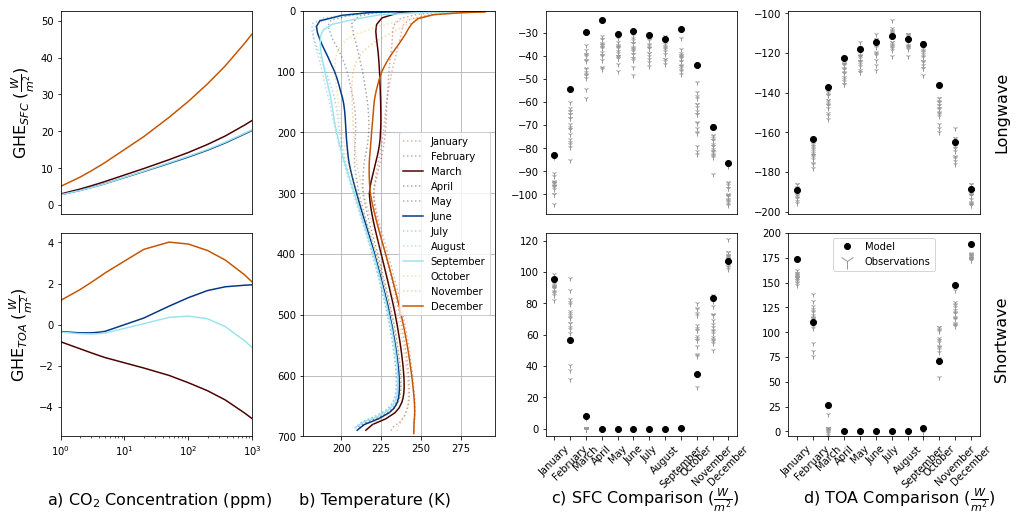

In [93]:
cmap = cmocean.cm.thermal(np.linspace(0,1,len(months)+1))
colors_dict = {'December':color_map[11],'March':color_map[2], 'June':color_map[5], 'September':color_map[8], 'January':color_map[0], 'February':color_map[1], 'November':color_map[9]}
color = iter(color_map)
fig = plt.figure(figsize = (14,7))
gs = fig.add_gridspec(2,4)
for month in ['December','March','June','September']:
    ax1 = fig.add_subplot(gs[0, 0])
    c = colors_dict[month]
    #GHE SFC plot
    x = month_ds_dict[month].co2_lev *ppm_convert
    y = month_ds_dict[month]['sfc_co2_effect']
    p1 = ax1.plot(x,y,
        label = month, 
        color = c)
    #GHE TOA plot
    ax2 = fig.add_subplot(gs[1,0])
    x = month_ds_dict[month].co2_lev *ppm_convert
    y = (month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'] - 
     month_ds_dict[month].sel(time = 0, model = 'rat').isel(lev_bounds = 0)['LW_flux_net_clr'])
    p2 = ax2.plot(x, y,
            label = month, 
             color = c)
for month in months:
    c = next(color)
    if month in ['December','March','June','September']:
        l = '-'
        a = 1
    else:
        l = ':'
        a = .35
        
     #add in the temperature profile
    x = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = times[0])['T']
    y =  month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1)['lev_full']
    ax_temp = fig.add_subplot(gs[:, 1])
    ax_temp.plot(x, y, label = month, color = c, linestyle = l, alpha = a)
    ax_temp.set_ylabel('')
    ax_temp.set_xlabel('')
    ax_temp.set_title(month)
    ax_temp.set_ylim(700,0)
    ax_temp.grid(True)
    ax_temp.set_title('')
    ax_temp.legend()
    
obs_color = '0.6'
model_color = 'k'
obs_shape = '1'
model_shape = 'o'
####SFC####  
for year in np.arange(2001,2019):
    ax_lw_sfc = fig.add_subplot(gs[0, 2])
    ax_lw_sfc.plot(ds_obs['sfc_net_lw_clr_t_mon'].sel(lat = -89.5, lon = 140.5).sel(time=ds_obs.time.dt.year.isin([year])), color = obs_color, marker = obs_shape, linestyle = 'None')
for idx, month in enumerate(months):
    ax_lw_sfc.plot(month, -month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0.00038).isel(lev_bounds = -1)['LW_flux_net_clr'], color = model_color, marker = model_shape, linestyle = 'None') #have to make negative because of the difference in output of sign
    hand, labl = ax_lw_sfc.get_legend_handles_labels()

for year in np.arange(2001,2019):
    ax_sw_sfc = fig.add_subplot(gs[1, 2])
    ax_sw_sfc.plot(ds_obs['sfc_net_sw_clr_t_mon'].sel(lat = -89.5, lon = 140.5).sel(time=ds_obs.time.dt.year.isin([year])), color = obs_color, marker = obs_shape, linestyle = 'None')
for idx, month in enumerate(months):
    ax_sw_sfc.plot(month, month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0.00038).isel(lev_bounds = -1)['SW_flux_net_clr'], color = model_color, marker = model_shape, linestyle = 'None') #have to make negative because of the difference in output of sign
    hand, labl = ax_sw_sfc.get_legend_handles_labels()
    ax_sw_sfc.set_ylim(-5,125)
####TOA####
for year in np.arange(2001,2019):
    ax_lw_toa = fig.add_subplot(gs[0, 3:])
    ax_lw_toa.plot(-ds_obs['toa_lw_clr_t_mon'].sel(lat = -89.5, lon = 140.5).sel(time=ds_obs.time.dt.year.isin([year])),color = obs_color, marker = obs_shape, linestyle = 'None')
for idx, month in enumerate(months):
    ax_lw_toa.plot(month, -month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0.00038).isel(lev_bounds = 0)['LW_flux_net_clr'], color =model_color, marker = model_shape, linestyle = 'None') #have to make negative because of the difference in output of sign
    hand, labl = ax_lw_toa.get_legend_handles_labels()

for year in np.arange(2001,2019):
    ax_sw_toa = fig.add_subplot(gs[1, 3:]) 
    ax_sw_toa.plot((ds_obs['solar_mon'].sel(lat = -89.5, lon = 140.5).sel(time=ds_obs.time.dt.year.isin([year]))-ds_obs['toa_sw_clr_t_mon'].sel(lat = -89.5, lon = 140.5).sel(time=ds_obs.time.dt.year.isin([year]))), 
                   color =obs_color, marker = obs_shape, label = 'Observations', linestyle = 'None')
for idx, month in enumerate(months):
    ax_sw_toa.plot(month, month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0.00038).isel(lev_bounds = 0)['SW_flux_net_clr'], color =model_color, marker = model_shape, label = 'Model', linestyle = 'None') #have to make negative because of the difference in output of sign
    hand, labl = ax_sw_toa.get_legend_handles_labels()
    legend_elements = [Line2D([0], [0], marker = model_shape, linestyle = None, color=model_color, lw=0, label='Model'),
                       Line2D([0], [0], marker=obs_shape,  linestyle = None, color=obs_color, lw=0, label='Observations', markersize=15)]
    ax_sw_toa.legend(handles=legend_elements, loc='best')
    ax_sw_toa.set_ylim(-5,200)
#set up labels
ax1.set_ylabel(r'GHE$_{SFC}\; (\frac{W}{m^2})$', fontsize = 16)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax2.set_ylabel(r'GHE$_{TOA}\; (\frac{W}{m^2})$', fontsize = 16)
ax_lw_sfc.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax_lw_toa.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax_sw_toa.set_xticklabels(months, rotation = 45)
ax_sw_sfc.set_xticklabels(months, rotation = 45)
#set x labels
fig.text(0.05,0, 'a) CO$_2$ Concentration (ppm)', va='center', rotation='horizontal', fontsize = 16)
fig.text(0.3, 0,  'b) Temperature (K)', va='center', rotation='horizontal', fontsize = 16)
fig.text(0.55, 0, r'c) SFC Comparison ($\frac{W}{m^2}$)', va='center', rotation='horizontal', fontsize = 16)
fig.text(0.8, 0, r'd) TOA Comparison ($\frac{W}{m^2}$)', va='center', rotation='horizontal', fontsize = 16)
#set lw and sw labels
fig.text(.99,.77, 'Longwave', va='center', rotation='vertical', fontsize = 16)
fig.text(.99,.32,  'Shortwave', va='center', rotation='vertical', fontsize = 16)
#set xaxis to log scale
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_xlim(1,10e2)
ax2.set_xlim(1,10e2)
#set up legends

line = Line2D([0,1],[0,1],linestyle='-', color='k')
dots = Line2D([0,1],[0,1],linestyle='--', color='k')

plt.tight_layout()
plt.savefig('../figures/GH_sfc_CO2_effect.png', dpi = 150, bbox_inches = 'tight')


# Surface CO2 Effect

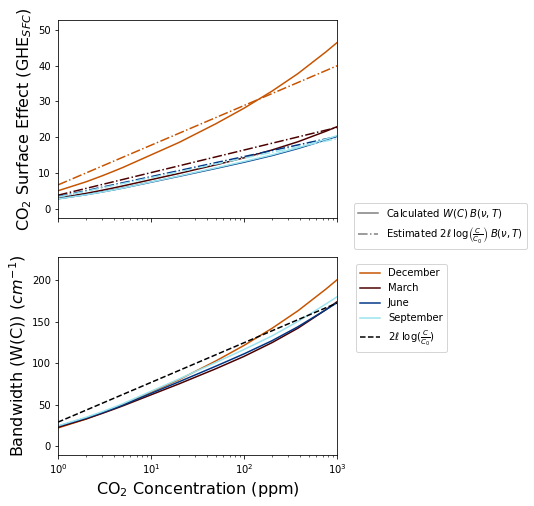

In [53]:
colors_dict = {'December':color_map[11],'March':color_map[2], 'June':color_map[5], 'September':color_map[8]}

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,8))
for month in colors_dict.keys():
    c = colors_dict[month]
    
#### plot our co2 surface effect ####
    x = month_ds_dict[month].co2_lev *ppm_convert
    y = month_ds_dict[month]['sfc_co2_effect']
    ax1.plot(x,y,
        label = month, 
        color = c)
    #plt.xscale('log')
    ax1.plot(x, month_ds_dict[month]['sfc_co2_estimate'],
        color = c, linestyle = '-.')

#### plot our effective bandwidth ####
    x = month_ds_dict[month].co2_lev *ppm_convert
    y = month_ds_dict[month]['eff_bandwidth']
    ax2.plot(x,y,
        label = month, 
        color = c)
    #plt.xscale('log')
ax2.plot(x[1:], month_ds_dict[month]['eff_bandwidth_est'],
            label = r'$2 \ell  \; \log(\frac{C}{C_0})$',
        color = 'k', linestyle = '--')

ax2.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax2.set_ylabel(r'Bandwidth (W(C)) ($cm^{-1}$)', fontsize = 16)
ax2.legend(bbox_to_anchor = [1.05, .99]);
#set xaxis to log scale
ax1.set_xscale('log')
ax2.set_xscale('log')
#ax1.set_xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
ax1.set_ylabel(r'CO$_2$ Surface Effect (GHE$_{SFC})$', fontsize = 16)
#set x lims
ax1.set_xlim(1,10e2)
#create legend
line = Line2D([0,1],[0,1],linestyle='-', color='grey')
dots = Line2D([0,1],[0,1],linestyle='-.', color='grey')
ax1.legend([line, dots],[r'Calculated $W(C) \; B(\nu, T)$',r'Estimated $2 \ell \; \log\left(\frac{C}{C_0}\right) \; B(\nu, T)$ '], bbox_to_anchor = [1.7, 0.1])

plt.savefig('../figures/sfc_bandwidth_and_co2.png', dpi = 150, bbox_inches = 'tight')

# Column Temperature Difference (Doubled-Base)

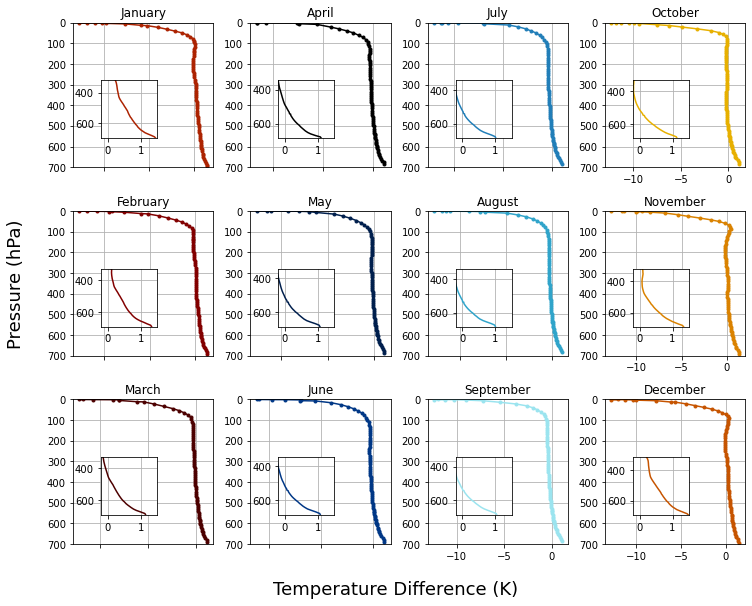

In [11]:
t = times[-1]

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

color = iter(color_map)

fig = plt.figure(figsize = (10,8))
gs = fig.add_gridspec(3,4)
for idx, month in enumerate(months):
    c = next(color)
    ax = fig.add_subplot(gs[np.mod(idx,3),idx//3])
    x1 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc1, time = t)['T']
    x2 = month_ds_dict[month].sel(model = 'rat', co2_lev = CO2_conc2, time = t)['T']
    y =  month_ds_dict[month].lev_full
    ax.plot(x2-x1, y, marker = '.', label = 'Temperature', c = c)
    ax.set_title(month)
    ax.set_ylim(700,0)
    ax.grid(True)
    if idx <= 7:
        ax.xaxis.set_ticklabels([])
    
    
    #inset axes
    axins = ax.inset_axes([.2,.2, .4,.4])
    axins.plot((x2-x1)[-40:], y[-40:], c = c)
    axins.set_ylim(y[-40:].max(),y[-40:].min())
    axins.set_xlim(-.2,1.5)
    axins.grid(True)
    
plt.tight_layout()
fig.text(0.5, -0.04, 'Temperature Difference (K)', ha='center', fontsize = 18)
fig.text(-0.04, 0.5, 'Pressure (hPa)', va='center', rotation='vertical', fontsize = 18)
plt.savefig('../figures/temp_dif.png', dpi = 150, bbox_inches = 'tight')

# Surface Temperature

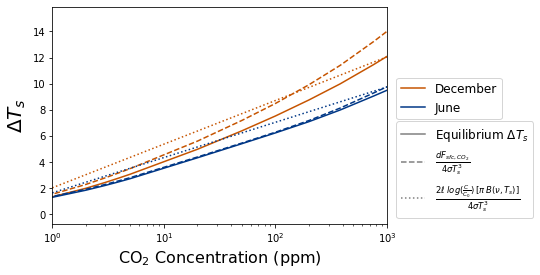

In [78]:
fig, ax1 = plt.subplots()
plot_lines = []
stef_boltz = 5.6E-8 #stefan boltzmann constant
for month in ['December','June']:
    c = colors_dict[month]
    #plot the calculated sfc co2 effect dTs
    y = month_ds_dict[month]['sfc_co2_effect']/(4*stef_boltz*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
    x = month_ds_dict[month]['co2_lev']*ppm_convert
    plot1 = plt.plot(x, y, label = month, linestyle = '--', color = c)
    #plot the model dTs
    y = (month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat')- 
     month_ds_dict[month]['T'].isel(lev_full = -1, time = -1).sel(model = 'rat', co2_lev = 0))
    plot2 = plt.plot(x, y, label = month, linestyle = '-', color = c)
    #plot the estimated sfc co2 effect dTs
    y = month_ds_dict[month]['sfc_co2_estimate']/(4*stef_boltz*month_ds_dict[month]['T'].isel(lev_full = -1, time = 0).sel(model = 'rat')**3)
    plot3 = plt.plot(x, y, label = month, linestyle = ':', color = c)
    #labels
    plt.ylabel(r'$\Delta T_s$', fontsize = 20)
    plt.xlabel(r'CO$_2$ Concentration (ppm)', fontsize = 16)
    plot_lines.append(plot2)
#set xaxis to log scale
plt.xscale('log')
plt.xlim(1,10e2)
#legends
line = Line2D([0,1],[0,1],linestyle='-', color='grey')
dash = Line2D([0,1],[0,1],linestyle='--', color='grey')
dot =  Line2D([0,1],[0,1],linestyle=':', color='grey')
legend1 = plt.legend([line, dash, dot],[r'Equilibrium $\Delta T_s$',
                                         r'$\frac{dF_{sfc,CO_2}}{4\sigma T_s^3}$', 
                                         r'$\frac{2 \ell \ log(\frac{C}{C_0})\:[\pi\, B(\nu, T_s)]}{4\sigma T_s^3}$'], fontsize = 12, bbox_to_anchor = [1.01, 0.5])
plt.legend([l[0] for l in plot_lines], ['December','June'], fontsize = 12, bbox_to_anchor = [1.01, 0.7])
plt.gca().add_artist(legend1)
plt.savefig('../figures/delta_Ts.png', dpi = 150, bbox_inches = 'tight')
